# The Beginning
Read the data, train and test in separate files

Variable |	Definition	| Key |
---------|--------------|-----|
survival |	Survival	| 0 = No, 1 = Yes
pclass   |	Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd
sex	| Sex
Age	| Age in years
sibsp |	# of siblings / spouses aboard the Titanic
parch |	# of parents / children aboard the Titanic
ticket |	Ticket number
fare | Passenger fare
cabin | Cabin number
embarked | Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix, accuracy_score

# Data

In [2]:
real_data = pd.read_csv('test.csv')
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing & EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Looking at how many Cabin observations are missing, I assume it would be OK to drop Cabin column as well as PassengerId

In [5]:
data = data.drop(['PassengerId', 'Cabin'], axis=1)

### Variable types:

Categorical: Survived, Sex, and Embarked.

Ordinal: Pclass

Continous: Age, Fare.

Discrete: SibSp, Parch.

In [6]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
data.describe(include=['O'])


,Name,Sex,Ticket,Embarked
count,891,891,891,889
unique,891,2,681,3
top,"Cacic, Mr. Luka",male,CA. 2343,S
freq,1,577,7,644


### Fill NaN in Age column
Since we have 177 NaN in Age colum and this feature is really important, let's try to fill NaNs there.
We can do iy according to Sex and/or Pclass. Let's have a look at median Age in males and females and Pclasses

First, let's check Age distribution

<AxesSubplot:xlabel='Age'>

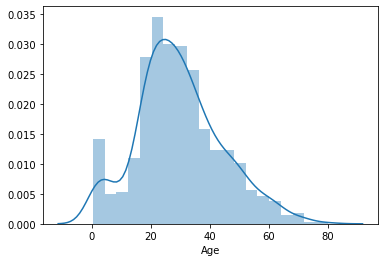

In [8]:
sns.distplot(data.Age)

#### Age ~ Sex

Sex
female    27.0
male      29.0
Name: Age, dtype: float64

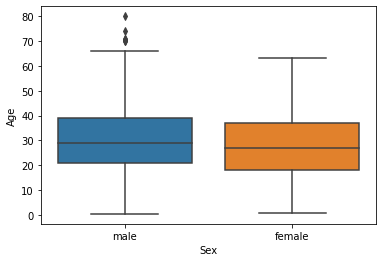

In [9]:
sns.boxplot(y='Age', x='Sex', data=data)
data.groupby(by='Sex').Age.median()

No big difference

#### Age ~ Pclass

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

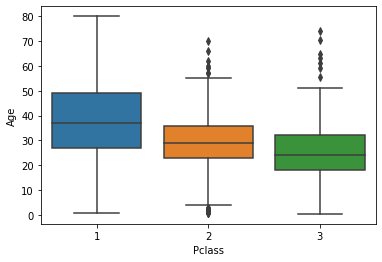

In [10]:
sns.boxplot(y='Age', x='Pclass', data=data)
data.groupby(by='Pclass').Age.median()

#### Let's fill Age NaNs with median Age in Pclass\*Sex groups

In [11]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [12]:
sexes = ['female', 'male']
for i in range(0, 2):
    for j in range(0, 3):
        guess_df = data[(data['Sex'] == sexes[i]) & (data['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

        age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

for i in range(0, 2):
    for j in range(0, 3):
        data.loc[ (data.Age.isnull()) & (data.Sex == sexes[i]) & (data.Pclass == j+1), 'Age'] = guess_ages[i,j]

    #data['Age'] = data['Age'].astype(int)

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [13]:
data.Age.isnull().sum()

0

And check Age distribution again

<AxesSubplot:xlabel='Age'>

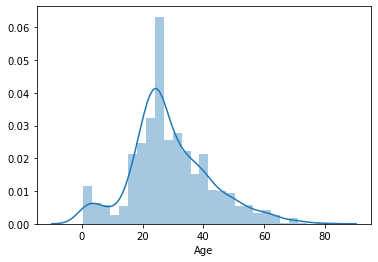

In [14]:
sns.distplot(data.Age)

In [15]:
# skip this simple all-median Age filling
#data = data.fillna({'Age': data.Age.median()})
data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
dtype: int64

### Fill NaN in Embarked

Embarked is the only feature with NaN
And there are only two empty obseravtions, so let's fill them using

In [16]:
set(data.Embarked)

{'C', 'Q', 'S', nan}

In [17]:
data = data.fillna(method='ffill')

In [18]:
data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

### Name length
Let's add Name length feature and look at its possible contribution to survival

In [19]:
data['Name_length'] = pd.Series(map(len, data.Name))

Survived
0    24.0
1    28.5
Name: Name_length, dtype: float64

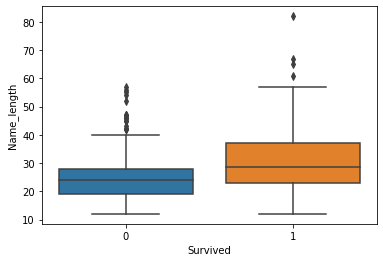

In [20]:
sns.boxplot(y='Name_length', x='Survived', data=data)
data.groupby(by='Survived').Name_length.median()

Quite a difference

Sex
female    30
male      24
Name: Name_length, dtype: int64

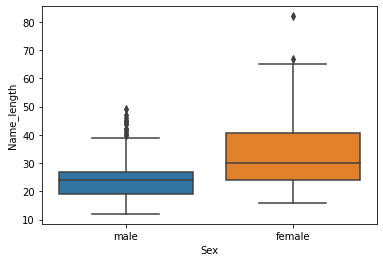

In [21]:
sns.boxplot(y='Name_length', x='Sex', data=data)
data.groupby(by='Sex').Name_length.median()

In [ ]:
list(data.Name)[0:12]

Women have longer names simply because pre-marriage name is also in this column.
And we see that name length differs between men and women, and mainly because of that.

But trees don't care about correlations, so let's use it.

One possible hypothesis is that passengers from the society's upper classes have longer names.
To check this hypothesis we should clean up Names - remove pre-marriage names in braces and short names within quotation marks

Another possibility is to extract titles (not just Mr., Miss amd Mrs, but also Lord, Sir, Master etc) that would correspond to sex and martial status and society class

### Extracting Titles from Name

In [23]:
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(data['Title'], data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


But these titles are too redundant and noisy, let's clean it up a bit

In [24]:

data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
    
data[['Title', 'Survived']].groupby(['Title'], as_index=False).median()

,Title,Survived
0,Master,1
1,Miss,1
2,Mr,0
3,Mrs,1
4,Other,0


### Family members and family size

Parch and SibSp can be used to infer family size

In [25]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

<AxesSubplot:xlabel='Survived', ylabel='FamilySize'>

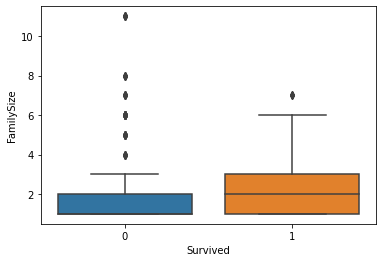

In [26]:
sns.boxplot(y='FamilySize', x='Survived', data=data)

### Drop Ticket, Name, SibSp, Parch

In [27]:
data = data.drop(['Ticket', 'Name', 'SibSp', 'Parch'], axis =1)
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Name_length,Title,FamilySize
0,0,3,male,22.0,7.2500,S,23,Mr,2
1,1,1,female,38.0,71.2833,C,51,Mrs,2
2,1,3,female,26.0,7.9250,S,22,Miss,1
3,1,1,female,35.0,53.1000,S,44,Mrs,2
4,0,3,male,35.0,8.0500,S,24,Mr,1


### Get dummies for Sex, Tile, Embarked

In [28]:
data = pd.get_dummies(data)

In [29]:
data = data.drop(['Sex_male'], axis=1)
data.head()

,Survived,Pclass,Age,Fare,Name_length,FamilySize,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,3,22.0,7.2500,23,2,0,0,0,1,0,0,1,0,0
1,1,1,38.0,71.2833,51,2,1,1,0,0,0,0,0,1,0
2,1,3,26.0,7.9250,22,1,1,0,0,1,0,1,0,0,0
3,1,1,35.0,53.1000,44,2,1,0,0,1,0,0,0,1,0
4,0,3,35.0,8.0500,24,1,0,0,0,1,0,0,1,0,0


### Combine Age and Pclass

In [30]:
data['Age_Class'] = data.Age * data.Pclass

### Pairplots

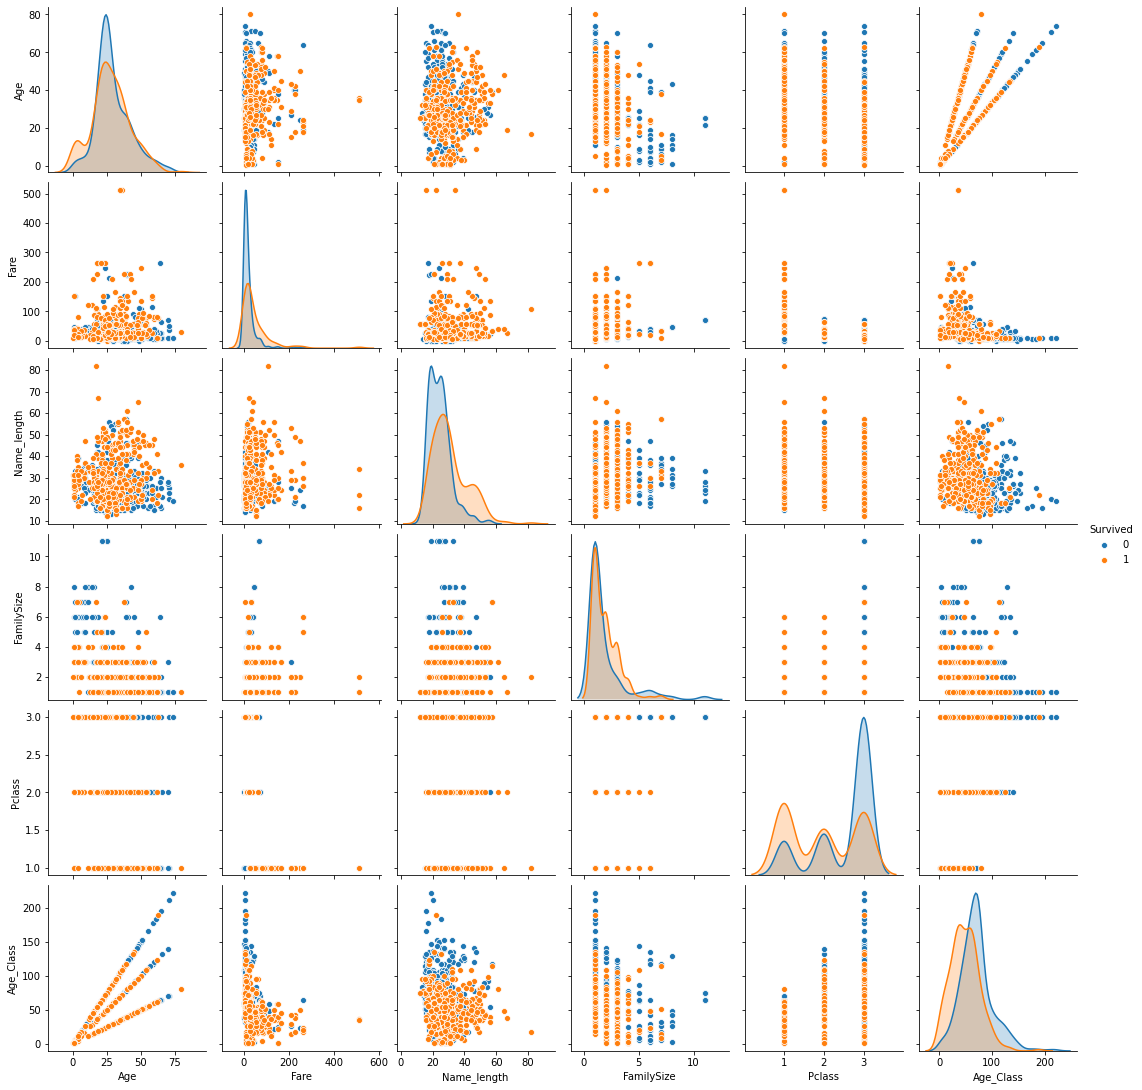

In [31]:
sns.pairplot(data[['Age', 'Fare', 'Name_length', 'FamilySize', 'Pclass', 'Age_Class','Survived']], hue='Survived')

In [32]:
data.head()

,Survived,Pclass,Age,Fare,Name_length,FamilySize,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Age_Class
0,0,3,22.0,7.2500,23,2,0,0,0,1,0,0,1,0,0,66.0
1,1,1,38.0,71.2833,51,2,1,1,0,0,0,0,0,1,0,38.0
2,1,3,26.0,7.9250,22,1,1,0,0,1,0,1,0,0,0,78.0
3,1,1,35.0,53.1000,44,2,1,0,0,1,0,0,0,1,0,35.0
4,0,3,35.0,8.0500,24,1,0,0,0,1,0,0,1,0,0,105.0


## Train and Test data

In [33]:

X = data.drop(['Survived'], axis=1)
Y = data.Survived

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

In [34]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 6 to 102
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        596 non-null    int64  
 1   Age           596 non-null    float64
 2   Fare          596 non-null    float64
 3   Name_length   596 non-null    int64  
 4   FamilySize    596 non-null    int64  
 5   Sex_female    596 non-null    uint8  
 6   Embarked_C    596 non-null    uint8  
 7   Embarked_Q    596 non-null    uint8  
 8   Embarked_S    596 non-null    uint8  
 9   Title_Master  596 non-null    uint8  
 10  Title_Miss    596 non-null    uint8  
 11  Title_Mr      596 non-null    uint8  
 12  Title_Mrs     596 non-null    uint8  
 13  Title_Other   596 non-null    uint8  
 14  Age_Class     596 non-null    float64
dtypes: float64(3), int64(3), uint8(9)
memory usage: 37.8 KB


How imbalanced are the classes?
(not much) 222 vs 324

In [35]:
len(Y_train[Y_train==0])

374

# Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

clf_rf = RandomForestClassifier(bootstrap=True, n_jobs=4, oob_score=False)

In [37]:
parameters_rf = {'n_estimators': [10, 20, 30, 40, 50, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': range(1,20),
              'min_samples_split': range(2, 10),
              'min_samples_leaf': range(1, 10),
              'min_impurity_decrease': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2],
              'ccp_alpha': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]}
# np.arange(0.0, 1.0, 0.1)

In [38]:
parameters_rf_2 = {'n_estimators': range(1, 400, 10),
              'criterion': ['gini', 'entropy'],
              'max_depth': range(1, 10),
              'min_samples_split': range(2, 10),
              'min_samples_leaf': range(1, 10),
              'min_impurity_decrease': [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2],
              'ccp_alpha': [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], 
              'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
              'max_features': ['auto', 'sqrt', 'log2']}


## Cross-validation and hyper-parameters fitting

In [39]:
rand_search_cv_clf_rf = RandomizedSearchCV(clf_rf, parameters_rf,
                                           cv=5, n_iter=20, random_state=1)

rand_search_cv_clf_rf.fit(X_train, Y_train)
rand_search_cv_clf_rf.best_params_

{'n_estimators': 30,
 'min_samples_split': 7,
 'min_samples_leaf': 6,
 'min_impurity_decrease': 0.0,
 'max_depth': 8,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

In [40]:
rand_search_cv_clf_rf_2 = RandomizedSearchCV(clf_rf, parameters_rf_2,
                                           cv=5, n_iter=30, random_state=1)

rand_search_cv_clf_rf_2.fit(X_train, Y_train)
rand_search_cv_clf_rf_2.best_params_

{'n_estimators': 131,
 'min_weight_fraction_leaf': 0.3,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'min_impurity_decrease': 0.0,
 'max_features': 'auto',
 'max_depth': 9,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

### Best hyperparameters

Parameters of the best classifier so far look like this:

{'n_estimators': 30,
 'min_samples_split': 7,
 'min_samples_leaf': 6,
 'min_impurity_decrease': 0.0,
 'max_depth': 8,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

In [41]:
best_clf = rand_search_cv_clf_rf.best_estimator_
# manual
# best_clf = RandomForestClassifier(n_estimators=30,
#                                   min_samples_split= 7,
#                                   min_samples_leaf= 6,
#                                   min_impurity_decrease= 0.0,
#                                   max_depth= 8,
#                                   criterion= 'gini',
#                                   ccp_alpha= 0.0)

### Distribution of predicted probabilities

<AxesSubplot:>

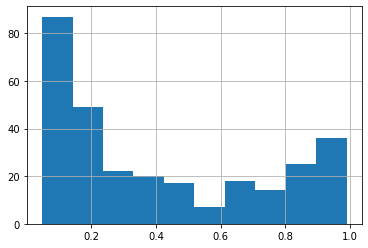

In [42]:
Y_pred_probs = best_clf.predict_proba(X_test)
# second column - prob of 1s (successes)
pd.Series(Y_pred_probs[:, 1]).hist()

In [43]:
# an array of alternative decisions with prob cut-off P
P = 0.5
Y_pred_ = np.where(Y_pred_probs[:, 1] > P, 1, 0)
accuracy_score(Y_test, Y_pred_)


0.8271186440677966

### Predictions on test dataset

In [44]:
Y_pred = best_clf.predict(X_test)

### Metrics

In [45]:
#accuracy = best_clf.score(X_test, Y_test)
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f_score = f1_score(Y_test, Y_pred)

metrics_df = pd.DataFrame({'acc':[accuracy], 'prec':[precision], 'recall':[recall], 'f1':[f_score]})
metrics_df


,acc,prec,recall,f1
0,0.827119,0.834951,0.716667,0.7713


Accuracy = 0.847

Precision = 0.838

Recall = 0.775

F1-score = 0.80

AUC = 0.91

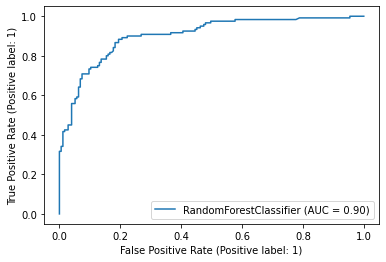

In [46]:
plot_roc_curve(best_clf, X_test, Y_test)

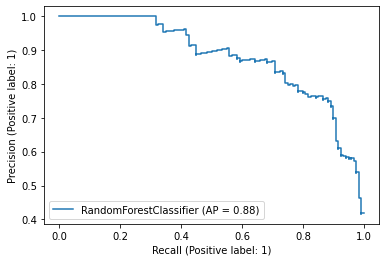

In [47]:
plot_precision_recall_curve(best_clf, X_test, Y_test)

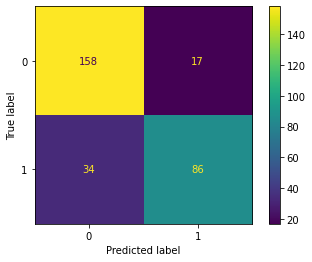

In [48]:
plot_confusion_matrix(best_clf, X_test, Y_test)

## Feature importance
Which features gave us most decrease of entropy?

NB: correlated features give you same importance, and they would be chosen randomly!

In [49]:
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': X_train.columns, 'importance': feature_importances})
feature_importances_df.sort_values('importance', ascending=False)

,features,importance
5,Sex_female,0.190037
11,Title_Mr,0.137680
14,Age_Class,0.109112
0,Pclass,0.096526
12,Title_Mrs,0.095489
2,Fare,0.080707
10,Title_Miss,0.071371
3,Name_length,0.065867
1,Age,0.061000
4,FamilySize,0.050971


Remember that correlated features split their importance (or share it?)

# Process Real Data to create submission

In [50]:
real_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [51]:
real_data = pd.read_csv('test.csv')

PassengerId_real = real_data.PassengerId

# Drop 0
real_data = real_data.drop(['PassengerId', 'Cabin'], axis=1)

# Age NA
guess_ages = np.zeros((2,3))
sexes = ['female', 'male']
for i in range(0, 2):
    for j in range(0, 3):
        guess_df = real_data[(real_data['Sex'] == sexes[i]) & (real_data['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

        age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

for i in range(0, 2):
    for j in range(0, 3):
        real_data.loc[ (real_data.Age.isnull()) & (real_data.Sex == sexes[i]) & (real_data.Pclass == j+1), 'Age'] = guess_ages[i,j]

# Embarked NA
real_data = real_data.fillna(method='ffill')

# Name length
real_data['Name_length'] = pd.Series(map(len, real_data.Name))

# Titles
real_data['Title'] = real_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
real_data['Title'] = real_data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

real_data['Title'] = real_data['Title'].replace('Mlle', 'Miss')
real_data['Title'] = real_data['Title'].replace('Ms', 'Miss')
real_data['Title'] = real_data['Title'].replace('Mme', 'Mrs')
    
#real_data[['Title', 'Survived']].groupby(['Title'], as_index=False).median()

# Family size
real_data['FamilySize'] = real_data['SibSp'] + real_data['Parch'] + 1

# Drop 1
real_data = real_data.drop(['Ticket', 'Name', 'SibSp', 'Parch'], axis =1)

# Age Pclass
real_data['Age_Class'] = real_data.Age * real_data.Pclass

# Dummies
real_data = pd.get_dummies(real_data)

# Drop Sex_male
real_data = real_data.drop(['Sex_male'], axis=1)

In [52]:
real_data

,Pclass,Age,Fare,Name_length,FamilySize,Age_Class,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,3,34.5,7.8292,16,1,103.5,0,0,1,0,0,0,1,0,0
1,3,47.0,7.0000,32,2,141.0,1,0,0,1,0,0,0,1,0
2,2,62.0,9.6875,25,1,124.0,0,0,1,0,0,0,1,0,0
3,3,27.0,8.6625,16,1,81.0,0,0,0,1,0,0,1,0,0
4,3,22.0,12.2875,44,3,66.0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,24.0,8.0500,18,1,72.0,0,0,0,1,0,0,1,0,0
414,1,39.0,108.9000,28,1,39.0,1,1,0,0,0,0,0,0,1
415,3,38.5,7.2500,28,1,115.5,0,0,0,1,0,0,1,0,0
416,3,24.0,8.0500,19,1,72.0,0,0,0,1,0,0,1,0,0


In [53]:
Y_real_pred = best_clf.predict(real_data)
submission = pd.DataFrame({'PassengerId': PassengerId_real, 'Survived': Y_real_pred})
submission

,PassengerId,Survived
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,1
414,1306,1
415,1307,1
416,1308,1


In [54]:
submission.to_csv('my_submission_3.csv', index=False)